In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [39]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [40]:
df.shape

(1460, 81)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [42]:
missing = df.isna().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing

Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

In [46]:
df.dropna?

In [47]:
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], axis=1, inplace=True)

In [48]:
df.shape

(1460, 75)

In [49]:
df.dropna(axis=0, inplace=True)

In [50]:
df.shape

(1338, 75)

In [51]:
numerical_features = [x for x in df.columns if df.dtypes[x] != 'object']
numerical_features.remove('Id')
# numerical_features

In [52]:
categorical_features = [x for x in df.columns if df.dtypes[x] == 'object']

In [58]:
for feature in categorical_features:
    df[feature] = df[feature].astype('category')
    df[feature] = df[feature].cat.codes

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1338 non-null   int64  
 1   MSSubClass     1338 non-null   int64  
 2   MSZoning       1338 non-null   int8   
 3   LotArea        1338 non-null   int64  
 4   Street         1338 non-null   int8   
 5   LotShape       1338 non-null   int8   
 6   LandContour    1338 non-null   int8   
 7   Utilities      1338 non-null   int8   
 8   LotConfig      1338 non-null   int8   
 9   LandSlope      1338 non-null   int8   
 10  Neighborhood   1338 non-null   int8   
 11  Condition1     1338 non-null   int8   
 12  Condition2     1338 non-null   int8   
 13  BldgType       1338 non-null   int8   
 14  HouseStyle     1338 non-null   int8   
 15  OverallQual    1338 non-null   int64  
 16  OverallCond    1338 non-null   int64  
 17  YearBuilt      1338 non-null   int64  
 18  YearRemo

In [92]:
df.drop(['Id', 'Exterior2nd', 'GarageArea', '1stFlrSF', 'GarageYrBlt'], axis=1).corr()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
MSSubClass,1.000000,0.019852,-0.134158,-0.020591,0.101590,0.004685,-0.023965,0.063066,-0.012477,-0.020367,...,-0.022598,-0.041391,-0.022748,0.010199,-0.021512,-0.016283,-0.021591,0.011012,-0.011692,-0.079599
MSZoning,0.019852,1.000000,-0.026123,0.100472,0.057472,-0.024760,-0.001048,-0.020602,-0.021658,-0.262624,...,0.144068,0.001516,0.022453,-0.002750,0.002839,-0.011369,-0.023209,0.092456,-0.003117,-0.163809
LotArea,-0.134158,-0.026123,1.000000,-0.215095,-0.162595,-0.169102,0.009710,-0.120209,0.458152,0.044572,...,-0.017968,0.019326,0.038489,0.077050,0.040824,0.000118,-0.012066,0.014410,0.031465,0.254757
Street,-0.020591,0.100472,-0.215095,1.000000,-0.004162,0.141519,0.001675,0.022597,-0.206116,-0.022545,...,0.021412,0.007269,-0.038169,0.004396,-0.026514,-0.001547,-0.036572,0.019380,0.011846,0.042106
LotShape,0.101590,0.057472,-0.162595,-0.004162,1.000000,0.083284,-0.036699,0.220790,-0.096193,-0.048163,...,0.074713,-0.038388,-0.047456,-0.018836,-0.042447,-0.043968,0.031659,-0.007836,-0.032899,-0.253092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MoSold,-0.016283,-0.011369,0.000118,-0.001547,-0.043968,-0.019251,-0.054038,0.016537,0.021693,0.005944,...,-0.022169,0.031341,0.023331,-0.035568,-0.008498,1.000000,-0.144862,-0.038388,0.026561,0.041310
YrSold,-0.021591,-0.023209,-0.012066,-0.036572,0.031659,0.018654,0.024555,-0.007448,-0.000975,0.037857,...,-0.006165,0.023326,0.013332,-0.061701,-0.002566,-0.144862,1.000000,0.005334,-0.006214,-0.020451
SaleType,0.011012,0.092456,0.014410,0.019380,-0.007836,-0.027535,-0.129813,0.007544,0.055246,-0.034072,...,-0.014236,-0.009785,0.006998,0.011886,0.014457,-0.038388,0.005334,1.000000,0.202453,-0.045856
SaleCondition,-0.011692,-0.003117,0.031465,0.011846,-0.032899,0.005750,-0.098211,0.059447,-0.059367,0.015369,...,-0.115526,-0.000002,-0.031065,-0.075309,0.009747,0.026561,-0.006214,0.202453,1.000000,0.202301


<AxesSubplot: >

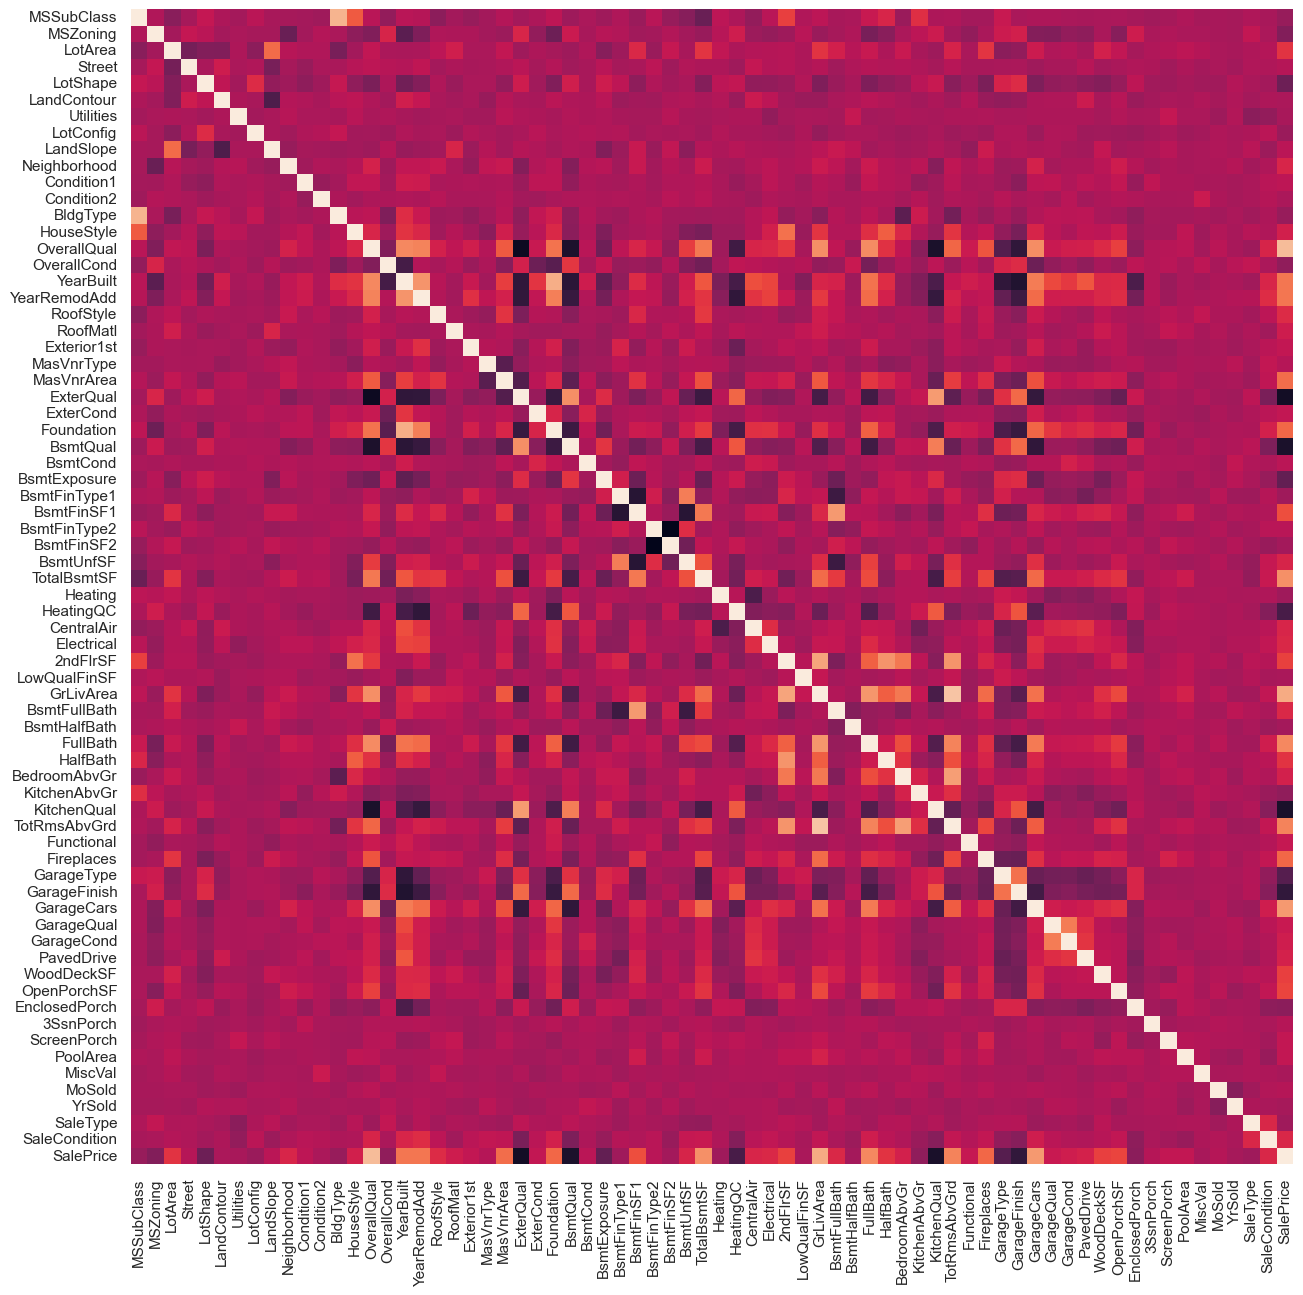

In [93]:
sns.set_theme()

# Load the example flights dataset and convert to long-form
# flights_long = sns.load_dataset("flights")
# flights = flights_long.pivot("month", "year", "passengers")
# print(flights_long)
# print(flights)
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.drop(['Id', 'Exterior2nd', 'GarageArea', '1stFlrSF', 'GarageYrBlt'], axis=1).corr(), cbar=False)

In [94]:
X = np.array(df.drop(['Id', 'SalePrice', 'Exterior2nd', 'GarageArea', '1stFlrSF', 'GarageYrBlt'], axis=1))
# X

In [95]:
y = np.array(df['SalePrice'])
# y

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [97]:
X_train

array([[5.0000e+01, 3.0000e+00, 1.0678e+04, ..., 2.0070e+03, 8.0000e+00,
        4.0000e+00],
       [9.0000e+01, 4.0000e+00, 9.1000e+03, ..., 2.0060e+03, 4.0000e+00,
        0.0000e+00],
       [4.5000e+01, 4.0000e+00, 6.1200e+03, ..., 2.0070e+03, 8.0000e+00,
        4.0000e+00],
       ...,
       [2.0000e+01, 3.0000e+00, 1.0000e+04, ..., 2.0070e+03, 8.0000e+00,
        4.0000e+00],
       [2.0000e+01, 3.0000e+00, 7.9430e+03, ..., 2.0070e+03, 8.0000e+00,
        4.0000e+00],
       [7.0000e+01, 4.0000e+00, 1.1700e+04, ..., 2.0090e+03, 8.0000e+00,
        4.0000e+00]])

In [98]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [99]:
model = LinearRegression()
model.fit(X_train, y_train)

print(f'Точность на тренировочных данных: {r2_score(y_train, model.predict(X_train))}')
print(f'Точность на тестовых данных: {r2_score(y_test, model.predict(X_test))}')

Точность на тренировочных данных: 0.9053118783572731
Точность на тестовых данных: 0.442379544634807


In [136]:
model = Lasso(alpha=15310)
model.fit(X_train, y_train)
print(f'Точность на тренировочных данных: {r2_score(y_train, model.predict(X_train))}')
print(f'Точность на тестовых данных: {r2_score(y_test, model.predict(X_test))}')

Точность на тренировочных данных: 0.7749592472200831
Точность на тестовых данных: 0.6138358551993637


In [101]:
model = Ridge(alpha=1300)
model.fit(X_train, y_train)
print(f'Точность на тренировочных данных: {r2_score(y_train, model.predict(X_train))}')
print(f'Точность на тестовых данных: {r2_score(y_test, model.predict(X_test))}')

Точность на тренировочных данных: 0.8552339349760303
Точность на тестовых данных: 0.648437365497814


In [102]:
model = ElasticNet(alpha=2)
model.fit(X_train, y_train)
print(f'Точность на тренировочных данных: {r2_score(y_train, model.predict(X_train))}')
print(f'Точность на тестовых данных: {r2_score(y_test, model.predict(X_test))}')

Точность на тренировочных данных: 0.8667325280769067
Точность на тестовых данных: 0.6374402416503162


In [103]:
model = HuberRegressor(alpha=0.01)
model.fit(X_train, y_train)
print(f'Точность на тренировочных данных: {r2_score(y_train, model.predict(X_train))}')
print(f'Точность на тестовых данных: {r2_score(y_test, model.predict(X_test))}')

Точность на тренировочных данных: 0.87703975107221
Точность на тестовых данных: 0.626842520640787


In [326]:
plt.figure(figsize=(10, 10))
plt.plot.sinology(model.predict(X_train), color='red')
# plt.plot(y_train, color='blue')

AttributeError: 'function' object has no attribute 'sinology'

<Figure size 1000x1000 with 0 Axes>